Poisson Equation:

$$
\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b
$$

Final discretized form after being rearranged:

$$
p_{i,j}^{k+1}=\frac{(p_{i+1,j}^{k}+p_{i-1,j}^{k})\Delta y^2+(p_{i,j+1}^{k}+p_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

Let's consider the following Poisson equation:

$$
\begin{equation}
\nabla^2 p = -2\left(\frac{\pi}{2}\right)^2\sin\left( \frac{\pi x}{L_x} \right) \cos\left(\frac{\pi y}{L_y}\right)
\end{equation}
$$

in the domain 

$$
\left\lbrace \begin{align*}
0 &\leq x\leq 1  \\
-0.5 &\leq y \leq 0.5 
\end{align*} \right.
$$

where $L_x = L_y = 1$ and with Dirichlet boundary conditions 

$$p=0 \text{ at } \left\lbrace 
\begin{align*}
x&=0\\
y&=0\\
y&=-0.5\\
y&=0.5
\end{align*} \right.$$

To solve this equation, we assume an initial state of $p=0$ everywhere, apply the boundary conditions and then iteratively relax the system until we converge on a solution.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from mpl_toolkits import mplot3d
from matplotlib import cm

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
#Set parameters
nx = 41
ny = 41
xmin, xmax = 0.0, 1.0
ymin, ymax = -0.5, 0.5
Lx = xmax - xmin
Ly = ymax - ymin
dx = (xmax - xmin)/(nx - 1)
dy = (ymax - ymin)/(ny - 1)

x = numpy.linspace(xmin, xmax, num = nx)
y = numpy.linspace(ymin, ymax, num = ny)

The source term mentioned in the lesson notebook theory is different than the one in the poisson_source term. Using the one given in the function will give results corresponding to the lesson notebook

In [4]:
def poisson_source(x, y, Lx, Ly):
    
    X, Y = numpy.meshgrid(x, y)
    b = -2.0 * ((numpy.pi)**2/(Lx*Ly)) * (numpy.sin((numpy.pi*X)/Lx)) * (numpy.cos((numpy.pi*Y)/Ly))
    
    return b                                                        

In [6]:
def l2_norm(p2, p1):
    
    """
    p2 = updated p after one iteration i.e. p^k+1
    
    p1 = previous p before the iteration i.e. p^k
    
    """
    
    error = (numpy.sqrt(numpy.sum((p2 - p1)**2))) / (numpy.sqrt(numpy.sum(p1**2)))
    
    return error

In [8]:
def poisson_2d_jacobi(p0, b , dx, dy, maxiter = 20000, rtol = 1e-6):
    
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    conv = []
    while diff>rtol and ite<maxiter:
        pn = p.copy()
        #Jacobi method for 2d poisson eqn internal points
        #p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, :-2])*dy**2 + (pn[2:, 1:-1] + pn[:-2, 1:-1]*dx**2) - b[1:-1, 1:-1]*dx**2*dy**2) / (2.0*(dx**2 + dy**2)))
        
        p[1:-1, 1:-1] = (((pn[1:-1, :-2] + pn[1:-1, 2:]) * dy**2 +
                          (pn[:-2, 1:-1] + pn[2:, 1:-1]) * dx**2 -
                          b[1:-1, 1:-1] * dx**2 * dy**2) /
                         (2.0 * (dx**2 + dy**2)))        
        #right side neumann condition with 2nd order discretization
        #p[1:-1, -1] = 0.25*(p[:-2, -1] + p[2:, -1] + 2*p[1:-1, -2])
        
        diff = l2_norm(p, pn)
        conv.append(diff)
        ite += 1
        
    return p, conv, ite              

In [9]:
#function of 3D plot
def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """
    Creates a Matplotlib figure with a 3D surface plot
    of the scalar field p.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction;
        default: 'z'.
    elev : float, optional
        Elevation angle in the z plane;
        default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane;
        default: 45.0.
    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    fig.add_axes(ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


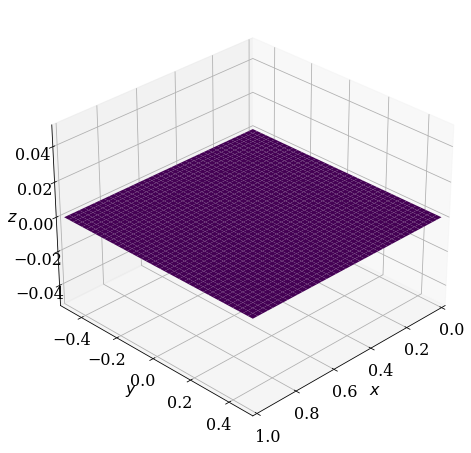

In [10]:
#Initial conditions : initial guess = all points 0, with all boundaries at 0
p0 = numpy.zeros((nx, ny))
#p0[-1, :] = numpy.sin(1.5*numpy.pi*x / Lx)

b = poisson_source(x, y, Lx, Ly)

plot_3d(x, y, p0)

In [11]:
p, conv, ite  = poisson_2d_jacobi(p0, b, dx, dy, maxiter = 20000, rtol = 2e-7)

print('Jacobi relaxation: {} iterations '.format(ite) +
      'to reach a relative difference of {}'.format(conv[-1]))

c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Jacobi relaxation: 3125 iterations to reach a relative difference of 1.9958631078740742e-07


c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


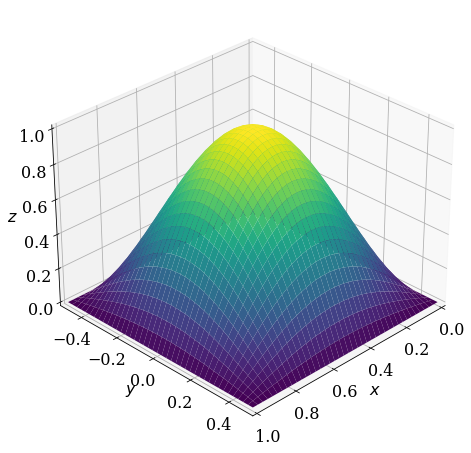

In [12]:
plot_3d(x, y, p)

In [13]:
def poisson_solution(x, y, Lx, Ly):
    
    X, Y = numpy.meshgrid(x, y)
    p_analytical = numpy.sin(numpy.pi * X/ Lx) * numpy.cos(numpy.pi * Y /Ly)
    
    return p_analytical

In [14]:
p_exact = poisson_solution(x, y, Lx, Ly)

In [15]:
l2_norm(p, p_exact)

0.00044962635351969427

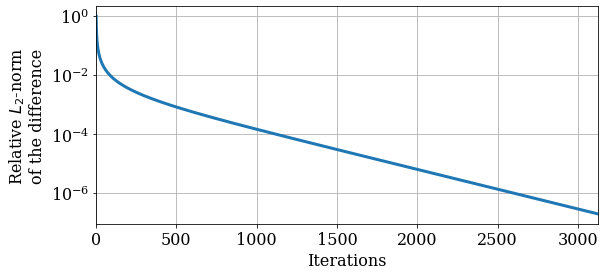

In [16]:
#plotting alegebraic convergence while iterations

pyplot.figure(figsize = (9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv, color = 'C0', linestyle='-', linewidth = 3)
pyplot.xlim(0, len(conv));

In [17]:
#Spatial convergence
#list of the grid sizes to investigate

nx_values = [11, 21, 41, 81]

#Create an empty list to store error on each grid
errors = []
for nx in nx_values: 
    ny = nx
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)
    #create the gridlines locations
    x = numpy.linspace(xmin, xmax, num=nx)
    y = numpy.linspace(ymin, ymax, num=ny)
    
    p0 = numpy.zeros((ny, nx))
    b = poisson_source(x, y, Lx, Ly)
    p, _, ites = poisson_2d_jacobi(p0, b, dx, dy, rtol=2e-7)
    print('[nx = {}] Number of Jacobi iterations: {}'.format(nx, ites))
    # Compute the analytical solution.
    p_exact = poisson_solution(x, y, Lx, Ly)
    # Compute and record the relative L2-norm of the error.
    errors.append(l2_norm(p, p_exact))   

c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


[nx = 11] Number of Jacobi iterations: 249
[nx = 21] Number of Jacobi iterations: 892
[nx = 41] Number of Jacobi iterations: 3125
[nx = 81] Number of Jacobi iterations: 10708


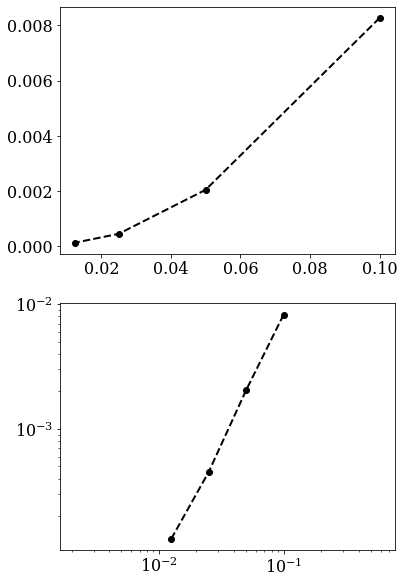

In [18]:
# Plot the error versus the grid-spacing size.
pyplot.figure(figsize=(6.0, 10.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.grid()
dx_values = Lx / (numpy.array(nx_values) - 1)
pyplot.subplot(2,1,1)
pyplot.plot(dx_values, errors, color='black', linestyle='--', linewidth=2, marker='o')
pyplot.subplot(2,1,2)
pyplot.loglog(dx_values, errors, color='black', linestyle='--', linewidth=2, marker='o')
pyplot.axis('equal');